

---



# *Project Start*


*   Install and Import important Packages
*   Import the model
*   Transform the images
*   Generate Predicitons




# Install and Import Important Packages

In [1]:
pip install -q --no-cache-dir -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import cv2
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split


from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
%matplotlib inline
print('Notebook run using keras:', keras.__version__)
#display
from IPython.display import Image, display
from omegaconf import OmegaConf

Notebook run using keras: 3.5.0


# Set Directories

In [3]:
# Read pickles from the path specified in config.dest_file
config_path = "config.yaml"  # Replace with the path to your config file
config = OmegaConf.load(config_path)
folder_path = config.folder_path
path = config.path
model_path = config.model_path
csv_path = config.csv_path
output_dir = config.output_dir
# Load the DataFrame from the CSV file
print(folder_path, path, model_path)

C:\Users\saadr\Desktop\data_XAI\data\pancreas\pancreas C:\Users\saadr\Desktop\data_XAI\data\pancreas\pancreas\image C:\Users\saadr\Desktop\data_XAI\models


In [4]:
# Define paths for your splits
train_dir = os.path.join(folder_path, 'train')
val_dir = os.path.join(folder_path, 'val')
test_dir = os.path.join(folder_path, 'test')



---



In [5]:
folder_path

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas'

---


# Model Fine Tuning

In [9]:
batch_size = 16
img_height = 299
img_width = 299

In [ ]:
import model.model_training_tuning as model_training_tuning
import model.model_training as model_training


In [10]:
from model.model_training_preprocessing import model_training_preprocessing

# Step 1: Instantiate the class
trainer = model_training_preprocessing(
    train_dir,
    val_dir,
    test_dir,
    batch_size=batch_size,
    img_height=img_height,
    img_width=img_width
)

# Step 2: Load the raw datasets
train_ds, val_ds, test_ds = trainer.load_data()

# Step 3: Preprocess the datasets (with augmentation for training)
train_ds, val_ds, test_ds = trainer.preprocess_data(train_ds, val_ds, test_ds)

# Now you can use train_ds, val_ds, test_ds in model.fit(), etc.

Found 259 files belonging to 2 classes.
Number of training batches:   17
Total training samples:       272
Found 56 files belonging to 2 classes.
Number of validation batches: 4
Total validation samples:     64
Found 56 files belonging to 2 classes.
Number of test batches:       4
Total test samples:           64


# Keras Model Loading

In [87]:
#model.save(path +'./model_xception_batch16_epoch5_imgsize299.keras')
#model= loaded_model = tf.keras.models.load_model('inceptionV5_.keras')
model= loaded_model = keras.applications.Xception(weights="imagenet")

In [ ]:
# Load the saved model
#model= loaded_model = keras.models.load_model(model_path +'./model_xception_batch16_epoch5_imgsize299.keras')

# Print the model summary
print(loaded_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 4,100 (16.02 KB)

None


In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
import cv2

# -----------------------------
# PARAMETERS
# -----------------------------
model = model  # your fine-tuned Xception model
image_dir = path_test      # test images directory
shap_dir = os.path.join(output_dir, 'shap_heatmaps_final_224')
os.makedirs(shap_dir, exist_ok=True)
target_size = (224, 224)  # new visualization size

# -----------------------------
# IMAGE LOADING
# -----------------------------
def load_and_preprocess_img(img_path):
    """Load and preprocess a single image for Xception."""
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Get image paths
img_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]

# -----------------------------
# SHAP EXPLAINER
# -----------------------------
# Reduce the number of background images to avoid MemoryError
background_imgs = np.concatenate([load_and_preprocess_img(p) for p in img_paths[:5]], axis=0)
#background = batch_imgs[:20]

# Use Image masker
masker = shap.maskers.Image("inpaint_telea", (299, 299, 3))
explainer = shap.Explainer(model, masker)


heatmap_shap=[]

# -----------------------------
# PROCESS AND SAVE HEATMAPS
# -----------------------------
for i, img_path in enumerate(img_paths):
    print(f"Processing image {i+1}/{len(img_paths)}: {os.path.basename(img_path)}")

    # Load image
    img_array = load_and_preprocess_img(img_path)
    preds = model.predict(img_array)

    top_class_idx = np.argmax(preds[0])
    def model_top_class(x):
        return model(x)[:, top_class_idx:top_class_idx+1]
    explainer = shap.Explainer(model_top_class, masker)

    #explainer = shap.Explainer(model, masker)
    shap_values = explainer(img_array, max_evals=300)


    # Compute SHAP values
    #explainer = shap.Explainer(model, masker, outputs=top5)

    #shap_values = explainer(img_array, max_evals=200)

    # -----------------------------
    # GRAYSCALE HEATMAP
    # -----------------------------
    shap_map = np.sum(np.abs(shap_values[0]), axis=-1)  # sum over RGB channels
    print("SHAP max:", shap_map.max(), "min:", shap_map.min(), shap_map.min())
    shap_map = (shap_map - shap_map.min()) / (shap_map.max() - shap_map.min() + 1e-8)  # normalize 0-1
    shap_map_resized = cv2.resize(shap_map[0], target_size)  # resize to 224x224


    heatmap_shap.append(shap_map_resized)

    plt.figure(figsize=(6,6))
    plt.imshow(shap_map_resized, cmap='hot')
    plt.axis('off')
    save_path_gray = os.path.join(shap_dir, os.path.basename(img_path).replace(".png", "_shap_gray_224.png"))
    plt.savefig(save_path_gray, dpi=300, bbox_inches='tight')
    plt.close()

    # -----------------------------
    # OVERLAY HEATMAP ON ORIGINAL IMAGE (RGB)
    # -----------------------------
    original_img = img_array[0]  # remove batch dimension
    original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min() + 1e-8)  # normalize 0-1
    original_img_resized = cv2.resize(original_img, target_size)

    plt.figure(figsize=(6,6))
    plt.imshow(original_img_resized)
    plt.imshow(shap_map_resized, cmap='hot', alpha=0.5)  # overlay heatmap
    plt.axis('off')
    save_path_rgb = os.path.join(shap_dir, os.path.basename(img_path).replace(".png", "_shap_rgb_224.png"))
    plt.savefig(save_path_rgb, dpi=300, bbox_inches='tight')
    plt.close()


Processing image 1/44: pancreas_037.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:58, 58.33s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 2/44: pancreas_042.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:59, 59.24s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 3/44: pancreas_043.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:59, 59.71s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 4/44: pancreas_046.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:54, 54.22s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 5/44: pancreas_055.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.35s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 6/44: pancreas_056.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:52, 52.85s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 7/44: pancreas_061.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.76s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 8/44: pancreas_064.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.50s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 9/44: pancreas_070.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.10s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 10/44: pancreas_071.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.11s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 11/44: pancreas_092.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.18s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 12/44: pancreas_093.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.23s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 13/44: pancreas_102.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.13s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 14/44: pancreas_105.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.04s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 15/44: pancreas_114.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:54, 54.05s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 16/44: pancreas_117.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.17s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 17/44: pancreas_120.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.20s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 18/44: pancreas_137.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.15s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 19/44: pancreas_159.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:52, 52.25s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 20/44: pancreas_160.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:49, 49.69s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 21/44: pancreas_165.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:49, 49.24s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 22/44: pancreas_167.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:54, 54.72s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 23/44: pancreas_183.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.48s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 24/44: pancreas_215.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.40s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 25/44: pancreas_217.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.37s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 26/44: pancreas_222.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.68s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 27/44: pancreas_226.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.45s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 28/44: pancreas_229.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.96s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 29/44: pancreas_234.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.58s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 30/44: pancreas_253.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.43s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 31/44: pancreas_259.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.67s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 32/44: pancreas_265.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.92s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 33/44: pancreas_269.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.07s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 34/44: pancreas_280.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.49s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 35/44: pancreas_302.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.17s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 36/44: pancreas_310.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.86s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 37/44: pancreas_339.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.83s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 38/44: pancreas_354.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.69s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 39/44: pancreas_364.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.64s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 40/44: pancreas_378.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.33s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 41/44: pancreas_379.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.59s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 42/44: pancreas_391.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.52s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 43/44: pancreas_405.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.52s/it]               


SHAP max: 0.0 min: 0.0 0.0
Processing image 44/44: pancreas_418.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.76s/it]               


SHAP max: 0.0 min: 0.0 0.0


In [108]:
# save the heatmaps as pkl file
output_path = config.output_dir

import pickle


with open("heatmap_shap_224_444.pkl", 'wb') as f:
    pickle.dump(heatmap_shap, f)

In [109]:
# save heatmap
np.save(os.path.join(shap_dir, 'shap_heatmaps.npy'), np.array(heatmap_shap))

In [83]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Small background set (e.g., first 20 images)
background = batch_imgs[:20]

# Use Image masker
masker = shap.maskers.Image("inpaint_telea", (299, 299, 3))
explainer = shap.Explainer(model, masker, output_names=["cancer_score"])

# Explain one image at a time to save memory
i = 0
shap_out = explainer(batch_imgs[i:i+1], max_evals=200)

# Get grayscale SHAP map (sum abs across channels)
shap_map = np.sum(np.abs(shap_out.values[0]), axis=-1)

# Normalize
shap_map = (shap_map - shap_map.min()) / (shap_map.max() - shap_map.min() + 1e-8)

# Plot
plt.imshow(shap_map, cmap='hot')
plt.axis('off')
plt.show()


  0%|          | 0/198 [00:00<?, ?it/s]

MemoryError: Unable to allocate 2.00 GiB for an array with shape (268203, 1000) and data type float64

---


# Preprocess the images

## Transform the images

In [14]:
import os

path_test = os.path.join(test_dir,'pos' ) # Your path to the images
filenames = []

for filename in os.listdir(path_test):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other image extensions if needed
        filenames.append(filename)

print(f"Found {len(filenames)} images in the folder.")

Found 44 images in the folder.


In [16]:
df = df[df['img_idx'].isin(filenames)]


NameError: name 'df' is not defined

In [35]:
filenames[0]

'pancreas_037.png'

In [36]:
filenames

['pancreas_037.png',
 'pancreas_042.png',
 'pancreas_043.png',
 'pancreas_046.png',
 'pancreas_055.png',
 'pancreas_056.png',
 'pancreas_061.png',
 'pancreas_064.png',
 'pancreas_070.png',
 'pancreas_071.png',
 'pancreas_092.png',
 'pancreas_093.png',
 'pancreas_102.png',
 'pancreas_105.png',
 'pancreas_114.png',
 'pancreas_117.png',
 'pancreas_120.png',
 'pancreas_137.png',
 'pancreas_159.png',
 'pancreas_160.png',
 'pancreas_165.png',
 'pancreas_167.png',
 'pancreas_183.png',
 'pancreas_215.png',
 'pancreas_217.png',
 'pancreas_222.png',
 'pancreas_226.png',
 'pancreas_229.png',
 'pancreas_234.png',
 'pancreas_253.png',
 'pancreas_259.png',
 'pancreas_265.png',
 'pancreas_269.png',
 'pancreas_280.png',
 'pancreas_302.png',
 'pancreas_310.png',
 'pancreas_339.png',
 'pancreas_354.png',
 'pancreas_364.png',
 'pancreas_378.png',
 'pancreas_379.png',
 'pancreas_391.png',
 'pancreas_405.png',
 'pancreas_418.png']

In [19]:
images_path = path_test 

In [20]:
images_path

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas\\test\\pos'

In [23]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import xception

# Your folder path
#folder_path = 'path/to/your/images'

# Transform function
def transform_img_fn(images_path, target_size):
    out = []
    for img_path in images_path:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = xception.preprocess_input(x)  # Preprocessing for InceptionV3 (or any other model)
        out.append(x)
    return np.vstack(out)
target_size = (img_height, img_width)  # Example target size (height, width)
# Efficient Image Loading
images = []
for filename in os.listdir(images_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other image extensions if needed
        img_path = os.path.join(images_path, filename)
        # Append transformed image (processed & preprocessed)

        images.append(transform_img_fn([img_path], target_size)[0])

# Convert list to numpy array (final image dataset)
images = np.array(images)

print(f"Processed {len(images)} images.")

Processed 44 images.


In [24]:
print("Shape of images array:", images.shape)

Shape of images array: (44, 299, 299, 3)


In [26]:
out = test_ds

---

# Shap Implementation


In [54]:
import numpy as np
import shap
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
import os
# Xception model
model = Xception(weights='imagenet', include_top=True)
def load_and_preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Load all images from dataset folder
image_dir = path_test  # Replace with your image directory
img_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

# Preprocess all images
batch_imgs = np.concatenate([load_and_preprocess_img(p) for p in img_paths], axis=0)
# Use a small subset for SHAP background
background = batch_imgs[:50]  # First 50 images
# Use DeepExplainer and restrict to the top predicted class for each image
preds = model.predict(batch_imgs)
top_classes = np.argmax(preds, axis=1)

# Define a function that outputs only the top predicted class for each image
def f(X):
    preds = model(X)
    # Gather the output for the top class for each image in the batch
    return tf.stack([preds[i, top_classes[i]] for i in range(X.shape[0])])

explainer = shap.DeepExplainer((model.input, model.output), background)

# Compute SHAP values for the top class for each image
shap_values_batch = explainer.shap_values(batch_imgs)

# shap_values_batch is a list (one per class), but we want only the top class for each image
# We'll extract the SHAP values for the top class for each image
shap_heatmaps = []
for i, class_idx in enumerate(top_classes):
    # shap_values_batch[class_idx][i] has shape (299, 299, 3)
    shap_heatmaps.append(np.abs(shap_values_batch[class_idx][i]))
shap_heatmaps = np.array(shap_heatmaps)  # shape: (batch_size, 299, 299, 3)

# Convert to grayscale by summing channels
shap_heatmaps_gray = np.sum(shap_heatmaps, axis=-1)  # shape: (batch_size, 299, 299)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


C:\Users\saadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


StagingError: in user code:

    File "C:\Users\saadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_deep\deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_DepthwiseConv2dNative


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Top 5 predictions: [('n03920288', 'Petri_dish', np.float32(0.16661116)), ('n07768694', 'pomegranate', np.float32(0.08562013)), ('n03530642', 'honeycomb', np.float32(0.036266945)), ('n03476684', 'hair_slide', np.float32(0.031380296)), ('n04311174', 'steel_drum', np.float32(0.03124724))]


  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.89s/it]               


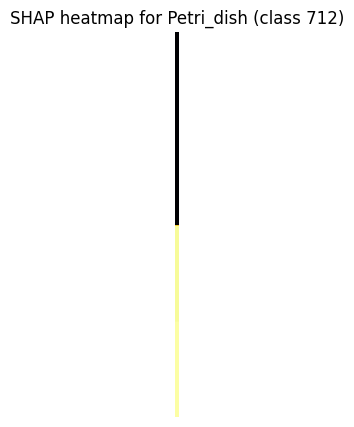

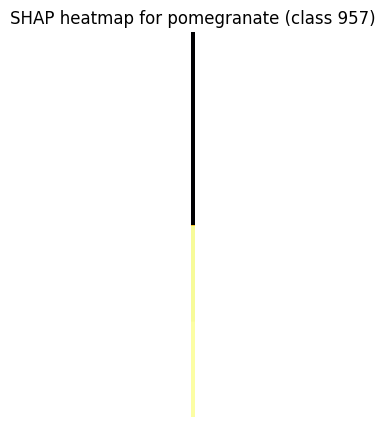

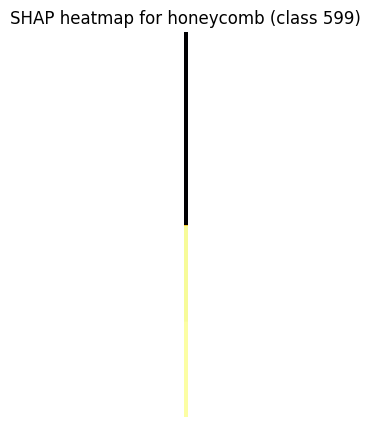

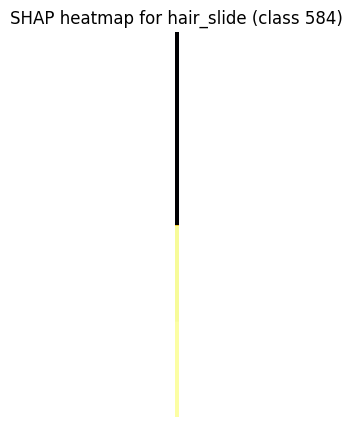

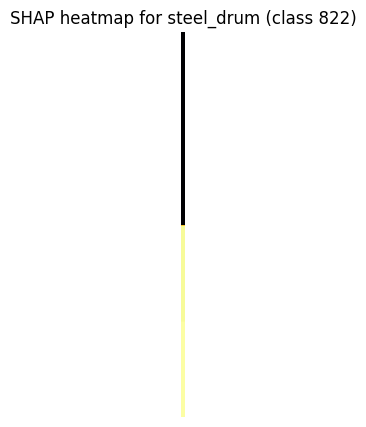

In [56]:
import numpy as np
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import os

# Load pretrained Xception
#model = Xception(weights="imagenet", include_top=True)

# Image loader
def load_and_preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Example: explain first image
img_path = img_paths[0]
img = load_and_preprocess_img(img_path)

# Predictions
preds = model.predict(img)
top5 = np.argsort(preds[0])[-5:][::-1]   # top-5 class indices
decoded = decode_predictions(preds, top=5)[0]
print("Top 5 predictions:", decoded)

# SHAP masker
masker = shap.maskers.Image("inpaint_telea", (299,299,3))

# Restrict explainer to top-5 outputs
explainer = shap.Explainer(model, masker, outputs=top5)

# Explain image
shap_out = explainer(img, max_evals=100)

# Visualize each class heatmap
for rank in range(len(top5)):
    class_idx = top5[rank]
    class_name = decoded[rank][1]   # safe: decoded always has length = top=5
    shap_map = np.sum(np.abs(shap_out.values[0][rank]), axis=-1)  # note the [0][rank]

    shap_map = (shap_map - shap_map.min()) / (shap_map.max() - shap_map.min() + 1e-8)

    plt.figure(figsize=(5,5))
    plt.imshow(shap_map, cmap="inferno")
    plt.title(f"SHAP heatmap for {class_name} (class {class_idx})")
    plt.axis("off")
    plt.show()



In [97]:
import os
import matplotlib.pyplot as plt
import shap
import numpy as np
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image

# Load pretrained Xception
model = Xception(weights="imagenet", include_top=True)

# Image loader
def load_and_preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Load one test image
img_path = img_paths[0]   # pick first image for example
img = load_and_preprocess_img(img_path)

# Predictions
preds = model.predict(img)
top5 = np.argsort(preds[0])[-5:][::-1]   # indices of top-5 classes
decoded = decode_predictions(preds, top=5)[0]
print("Top 5 predictions:", decoded)

# SHAP masker
masker = shap.maskers.Image("inpaint_telea", (299,299,3))

# Restrict explainer to top-5 outputs
explainer = shap.Explainer(model, masker, outputs=top5)

# Explain image
shap_out = explainer(img, max_evals=100)

# Output folder for heatmaps
shap_dir = os.path.join(output_dir, 'shap_heatmaps')
os.makedirs(shap_dir, exist_ok=True)

# Save each class heatmap
for rank in range(len(top5)):
    class_idx = top5[rank]
    class_name = decoded[rank][1]  # e.g., 'Egyptian_cat'

    # SHAP map (sum across channels -> grayscale)
    shap_map = np.sum(np.abs(shap_out.values[0][rank]), axis=-1)
    shap_map = (shap_map - shap_map.min()) / (shap_map.max() - shap_map.min() + 1e-8)

    plt.figure(figsize=(5,5))
    plt.imshow(shap_map, cmap="inferno")
    plt.axis("off")
    plt.title(f"{rank+1}: {class_name}")
    
    save_path = os.path.join(shap_dir, f"img0_top{rank+1}_{class_name}.jpg")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()

print(f"Saved heatmaps for {img_path} into {shap_dir}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Top 5 predictions: [('n03920288', 'Petri_dish', np.float32(0.16661116)), ('n07768694', 'pomegranate', np.float32(0.08562013)), ('n03530642', 'honeycomb', np.float32(0.036266945)), ('n03476684', 'hair_slide', np.float32(0.031380296)), ('n04311174', 'steel_drum', np.float32(0.03124724))]


  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.65s/it]               


Saved heatmaps for C:\Users\saadr\Desktop\data_XAI\data\pancreas\pancreas\test\pos\pancreas_037.png into C:\Users\saadr\Desktop\data_XAI\outputs\shap_heatmaps
